In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score, davies_bouldin_score
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [64]:
# Load the dataset
X_train = pd.read_csv("preprocessing_data.csv")

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap


def apply_scaling(data, method='standard',):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'standard', 'minmax', or 'robust'.")
    
    return scaler.fit_transform(data)


def apply_reduction(data, method='pca', n_components=2, random_state=42):
    if method == 'pca':
        reducer = PCA(n_components=0.995,random_state=random_state)
    elif method == 'umap':
        pca = PCA(random_state=random_state).fit(data)
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components_pca = np.argmax(cumulative_variance >= 0.995) + 1
        reducer =umap.UMAP(n_components=n_components_pca,random_state=random_state)
    else:
        raise ValueError("Invalid reduction method. Choose 'pca', or 'umap'.")
    
    return reducer.fit_transform(data)

In [66]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

def cluster_kmeans(data, cluster_method='kmeans', n_clusters=20, random_state=42,init='k-means++',n_init=50):
    model = KMeans(n_clusters=n_clusters, random_state=random_state, init='k-means++', n_init=n_init)
    labels = model.fit_predict(data)
    score = silhouette_score(data, labels)
    return score


In [67]:
scaling_methods = ['standard', 'minmax', 'robust']
reduction_methods = ['pca', 'umap']

results = []

for scale in scaling_methods:
    data_scaled = apply_scaling(X_train, method=scale)
    for reduction in reduction_methods:
        data_scaled = apply_reduction(data_scaled, method=reduction)
        score = cluster_kmeans(data_scaled)
        print(f'kmeans {scale}, {reduction}, {score}')
        results.append({
            'Scaling': scale,
            'Reduction': reduction,
            'Clustering': 'kmeans',
            'Silhouette Score': score

        })


kmeans standard, pca, -0.014877836257168382
kmeans standard, umap, 0.3778447210788727
kmeans minmax, pca, 0.05906299889099875
kmeans minmax, umap, 0.4784717261791229
kmeans robust, pca, 0.4479613944453816
kmeans robust, umap, 0.6262760162353516


In [68]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


def cluster_hierarchical(data =data, method = 'euclidean', metric = 'centrod'):
    distances = linkage(data)
    clusters = fcluster(distances,20,criterion = 'maxclust')
    score = silhouette_score(data, clusters, metric=metric)
    return score

In [69]:
scaling_methods = ['standard', 'minmax', 'robust']
reduction_methods = ['pca', 'umap']
metrics = ['euclidean', 'minkowski', 'cosine', 'cityblock']    
methods = ['centroid', 'single', 'complete', 'average']



for scale in scaling_methods:
    data_scaled = apply_scaling(X_train, method=scale)
    for reduction in reduction_methods:
        data_scaled = apply_reduction(data_scaled, method=reduction)
        for metric in metrics:
            for method in methods:
                score = cluster_hierarchical(data_scaled, method=method, metric=metric)
                print(f'hierarchical {metric}, {method},{scale}, {reduction},  {score}')
                results.append({
                    'Scaling': scale,
                    'Reduction': reduction,
                    'Clustering': f'hierarchical ({metric}, {method})',
                    'Silhouette Score': score
                })


hierarchical euclidean, centroid,standard, pca,  0.24549876142167976
hierarchical euclidean, single,standard, pca,  0.24549876142167976
hierarchical euclidean, complete,standard, pca,  0.24549876142167976
hierarchical euclidean, average,standard, pca,  0.24549876142167976
hierarchical minkowski, centroid,standard, pca,  0.24549876142167984
hierarchical minkowski, single,standard, pca,  0.24549876142167984
hierarchical minkowski, complete,standard, pca,  0.24549876142167984
hierarchical minkowski, average,standard, pca,  0.24549876142167984
hierarchical cosine, centroid,standard, pca,  -0.10410862740408242
hierarchical cosine, single,standard, pca,  -0.10410862740408242
hierarchical cosine, complete,standard, pca,  -0.10410862740408242
hierarchical cosine, average,standard, pca,  -0.10410862740408242
hierarchical cityblock, centroid,standard, pca,  0.08010619917690702
hierarchical cityblock, single,standard, pca,  0.08010619917690702
hierarchical cityblock, complete,standard, pca,  0.08

In [70]:
from sklearn.mixture import GaussianMixture

def cluster_gmm(data):
    # Create and fit the Gaussian Mixture Model
    model = GaussianMixture(n_components=20, random_state=42)
    model.fit(data)
    # Predict the labels
    labels = model.predict(data)
    # Calculate the silhouette score
    score = silhouette_score(data, labels)
    return score

In [71]:


for scale in scaling_methods:
    data_scaled = apply_scaling(X_train, method=scale)
    for reduction in reduction_methods:
        data_reduced = apply_reduction(data_scaled, method=reduction)
        score = cluster_gmm(data_reduced)
        print(f'gmm {scale}, {reduction}, {score}')
        results.append({
            'Scaling': scale,
            'Reduction': reduction,
            'Clustering': 'GMM',
            'Silhouette Score': score
        })


gmm standard, pca, -0.007614544352025601
gmm standard, umap, 0.37199684977531433
gmm minmax, pca, 0.03928578728276129
gmm minmax, umap, 0.42661675810813904
gmm robust, pca, -0.006221616698728771
gmm robust, umap, 0.546154797077179


In [72]:
best_params = max(results, key=lambda x: x['Silhouette Score'])

print("Best Parameters:\n", best_params)

Best Parameters:
 {'Scaling': 'robust', 'Reduction': 'umap', 'Clustering': 'kmeans', 'Silhouette Score': 0.626276}


In [73]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results.sort_values(by = "Silhouette Score", ascending=False).head(10).reset_index(drop=True)

,Scaling,Reduction,Clustering,Silhouette Score
0,robust,umap,kmeans,0.626276
1,robust,umap,GMM,0.546155
2,minmax,umap,kmeans,0.478472
3,robust,pca,kmeans,0.447961
4,minmax,umap,GMM,0.426617
5,robust,umap,"hierarchical (cityblock, average)",0.407159
6,robust,umap,"hierarchical (cityblock, complete)",0.407159
7,robust,umap,"hierarchical (cityblock, single)",0.407159
8,robust,umap,"hierarchical (cityblock, centroid)",0.407159
9,robust,umap,"hierarchical (minkowski, complete)",0.400315


In [ ]:
data_scaled = apply_scaling(X_train, method = best_params['Scaling'])
data_reduced = apply_reduction(data_scaled, method = best_params['Reduction'])
if best_params['Clustering']=='kmeans':
    model = KMeans(n_clusters=20, random_state=42, init='k-means++', n_init=50)
    labels = model.fit_predict(data_reduced)

elif best_params['Clustering']=='GMM':
    model = GaussianMixture(n_components=20, random_state=42)
    model.fit(data_reduced)
    labels = model.predict(data_reduced)

else:
    print("best clustering is hierarchical, do it manually")



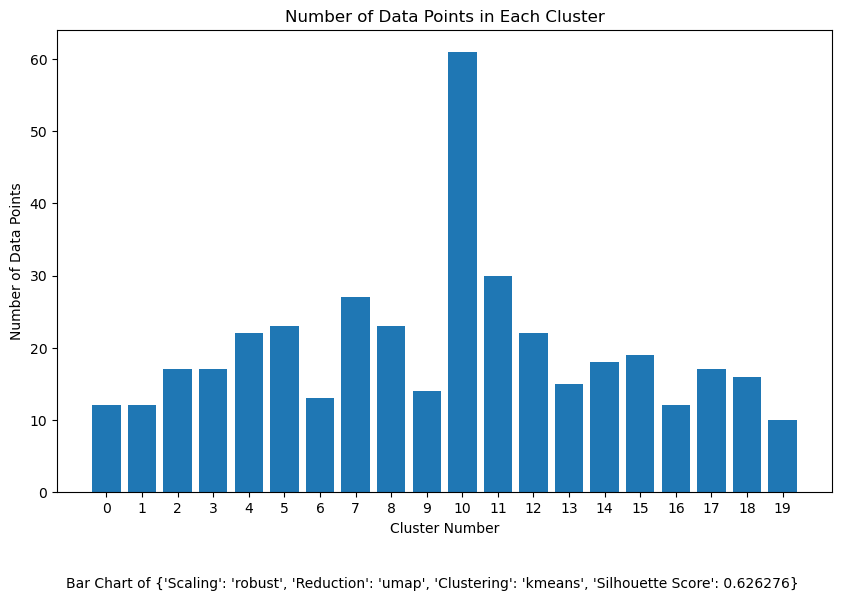

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of data points in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=unique_labels)
plt.xlabel('Cluster Number')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in Each Cluster')
plt.xticks(unique_labels)  # Show all cluster numbers as x-ticks

# Add a text description below the chart
plt.figtext(0.5, -0.05, f"Bar Chart of {best_params}", ha='center', fontsize=10)

plt.show()
